<a href="https://colab.research.google.com/github/levhojoyan/Sirius2021/blob/main/NeuralWithWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch import distributions as distrs


from sklearn.datasets import load_boston
from tqdm.notebook import tqdm

from IPython.display import clear_output

%matplotlib inline

Создадим искусственные данные для задачи регрессии: синус + нормальный шум


In [30]:
# Красиво рисует двумерное распределение
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)

In [31]:
sample_size = 100
x_s = torch.empty(sample_size).normal_(mean=0,std=1).unsqueeze(1)
noise_s = torch.empty(sample_size).normal_(mean=0,std=1)

f_s = torch.sin(x_s) # + noise_s 

sample_2d = torch.cat((x_s, f_s), 1)

print(sample_2d.shape)

torch.Size([100, 2])


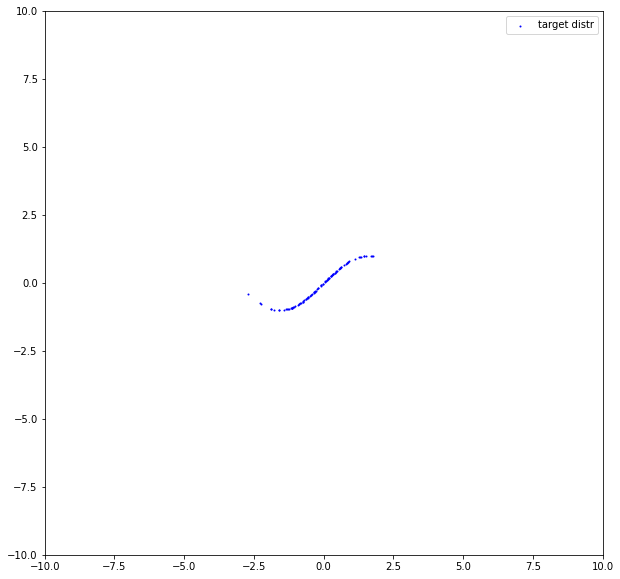

In [32]:
plt.figure(figsize=(10, 10))
plot_2d_dots(sample_2d, label='target distr')
plt.legend()
plt.show()

In [33]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x[idx], dtype=torch.float), 'target': self.y[idx]}

In [34]:
our_dataset = RandomDataset(x_s, f_s)
print(sample_2d.shape, x_s.shape)

torch.Size([100, 2]) torch.Size([100, 1])


In [35]:
our_dataset.__getitem__(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


{'sample': tensor([0.8435]), 'target': tensor([0.7470])}

In [36]:
sample_2d[1]

tensor([0.8435, 0.7470])

In [37]:
batch_size=16

In [46]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Linear(1, 5) # the simpliest
        # self.conv1 = nn.Linear(5, 5) # the simpliest
        self.conv2 = nn.Linear(5, 1)

    def forward(self, x):
      x = self.before_linear_mixture(x)
      return self.conv2(x)

    def before_linear_mixture(self, x):
      x = F.relu(self.conv1(x))
      return x

In [47]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)
train_size = int(sample_size * 0.7)
test_size = sample_size - train_size

In [48]:
for batch in dataloader:
    batch_x = batch['sample']
    batch_y = batch['target']
    break
print('Sample:', batch_x)
print('Target:', batch_y)

model = Model()
print(batch_x.shape)
y_pred = model(batch_x) # получили предсказания модели
loss = torch.nn.MSELoss()(batch_y, y_pred)
print(loss.data, y_pred)

Sample: tensor([[ 1.5127],
        [ 0.8435],
        [-0.8009],
        [ 0.8713]])
Target: tensor([[ 0.9983],
        [ 0.7470],
        [-0.7180],
        [ 0.7651]])
torch.Size([4, 1])
tensor(0.4031) tensor([[ 0.2069],
        [ 0.1564],
        [-0.1955],
        [ 0.1616]], grad_fn=<AddmmBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

torch.Size([100, 1]) torch.Size([100, 1, 1])


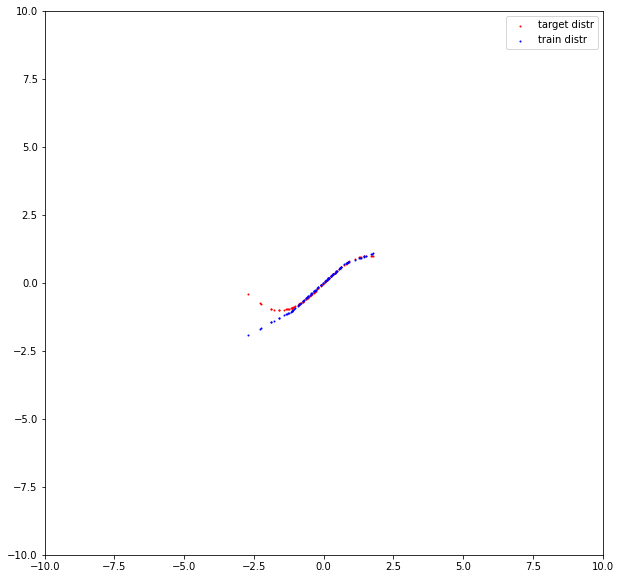

In [50]:
 
i = 0
for epoch in range(11):
  for x_train, y_train in tqdm(dataloader): # берем батч из трейн лоадера
      x_train = batch['sample']
      y_train = batch['target']

      print(x_train)
      y_pred = model(x_train) # делаем предсказания
      loss = torch.nn.MSELoss()(y_pred, y_train) # считаем лосс
      loss.backward() # считаем градиенты обратным проходом
      optimizer.step() # обновляем параметры сети
      optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1

      if i % 5 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))

        total_pred = model(x_s.unsqueeze(1))
        total_pred.detach_()
        print(x_s.shape, total_pred.shape)

        plot_2d_dots(sample_2d, color='r', label='target distr')
        plot_2d_dots(torch.cat((x_s.unsqueeze(1), total_pred), 1), color='b', label='train distr')
        plt.legend()
        plt.show() 

In [51]:
list(model.conv2.parameters())
model2 = Model()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.05)


In [52]:
print(model.conv2.weight)

Parameter containing:
tensor([[-0.5329,  0.3192,  0.1709,  0.3543,  0.4894]], requires_grad=True)


torch.Size([100, 1]) torch.Size([100])


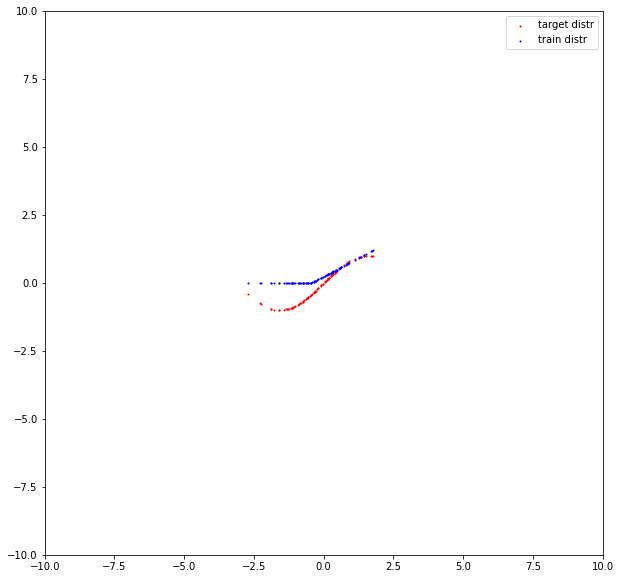

In [81]:
i = 0
for epoch in range(11):
  for x_train, y_train in tqdm(dataloader): # берем батч из трейн лоадера
      x_train = batch['sample']
      y_train = batch['target']

      print(x_train)
      y_pred = model2.before_linear_mixture(x_train) # делаем предсказания
      last_layer_weights = F.softmax(model2.conv2.weight)
      loss2 = torch.sum(last_layer_weights * ((y_pred - y_train)**2)) # считаем лосс
      print(loss2)
      loss2.backward() # считаем градиенты обратным проходом
      optimizer2.step() # обновляем параметры сети
      optimizer2.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1

      if i % 5 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        total_pred = torch.sum(model2.before_linear_mixture(x_s) * F.softmax(model2.conv2.weight), dim=1)
        total_pred.detach_()
        optimizer2.zero_grad()
        print(x_s.shape, total_pred.shape)

        plot_2d_dots(sample_2d, color='r', label='target distr')
        plot_2d_dots(torch.cat((x_s, total_pred[:, None]), 1), color='b', label='train distr')
        plt.legend()
        plt.show() 

In [75]:
print(model2.before_linear_mixture(x_s.unsqueeze(1))[0], F.softmax(model2.conv2.weight)[:, None])
x = model2.before_linear_mixture(x_s.unsqueeze(1)) * F.softmax(model2.conv2.weight)[:, None]
print(torch.sum(x, dim=2))
print(x[0], model2.before_linear_mixture(x_s.unsqueeze(1))[0] * F.softmax(model2.conv2.weight)[:, None])

tensor([[1.0627, 1.0503, 0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>) tensor([[[2.3394e-01, 7.6330e-01, 1.0315e-03, 1.0555e-03, 6.7660e-04]]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[1.0503e+00],
        [7.1158e-01],
        [0.0000e+00],
        [7.2562e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [4.6206e-01],
        [4.0860e-01],
        [0.0000e+00],
        [9.4832e-01],
        [3.7638e-01],
        [3.4138e-01],
        [1.0718e-04],
        [0.0000e+00],
        [6.8939e-01],
        [1.4703e-02],
        [0.0000e+00],
        [1.6743e-01],
        [5.0377e-01],
        [1.1197e-01],
        [1.1388e-02],
        [8.4821e-01],
        [1.0191e+00],
        [3.0025e-01],
        [0.0000e+00],
        [0.0000e+00],
        [5.8000e-01],
        [1.3701e-01],
        [4.5431e-01],
        [0.0000e+00],
        [7.0912e-01],
        [0.0000e+00],
        [4.0909e-02],
        [4.3049e-01],
        [0.0000e+00],
        [0.0000e+00],

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
